In [1]:
## Kalman filter
#    counter-current heat exchanger of Model 1
#Filename:Kalman-Filter-Model1.ipynb
#Author:Madhusudhan Pandey, USN, EPE
#Date: March 20, 2019
figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter3/";

using NLsolve
using DifferentialEquations
using Plots
pyplot();# pyplot attributes on backend
using LaTeXStrings;
using Compat, Random, Distributions
# Linewidths and styles
LW1 = 2 
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;
# inputs (need to specify first than parameters as Qdfs is input dependent and considered as parameters)

function u_Ifd(t)
    if isless(t, 3000)
        return 1055.
    elseif 3000<t<10000
        return 1.2*1055
    else
        return 0.5*1055
    end
    
end
Twc = 3.8
Ifd = 1055.
It = 5360.
QdFes = 212.
Wdf = 528.
mdw = 53.9
mda = 49.2


#
u = [Twc, Ifd, It, QdFes, Wdf, mdw, mda]

#Specifying Parameters
pa = 1.01e5 # " Atmospheric pressure , Pa "
#
chpa = 1.15 # " Specific heat capacity air , kJ.kg -1. K -1 # " 
chpw = 4.2 # " Specific heat capacity water , kJ.kg -1. K -1 # " 
chpCu = 0.385 # " Specific heat capacity copper , kJ.kg -1. K -1 # " 
chpFe = 0.465 # " Specific heat capacity iron , kJ.kg -1. K -1 # " 
#
mr = 9260. # " Mass of copper in rotor , kg # " 
ms = 6827. # " Mass of copper in stator , kg # " 
mFe = 71200. # " Mass of iron in stator , kg # " 
#
VhCu = 0.112e-3 # " Specific volume of copper , m3 / kg # " 
VhFe = 0.127e-3 # " Specific volume of iron , m3 / kg # " 
#
Vr = mr*VhCu # " Rotor copper volume , m3 # " 
Vs = ms*VhCu # " Stator copper volume , m3 # " 
VFe = mFe*VhFe # " Stator iron volume , m3 # " 
#
UAr2d = 2.7 # " Heat transfer , rotor copper to air gap , kW / K # " 
UAs2Fe = 20. # " Heat transfer , stator copper to stator iron , kW /K" 
UAFe2a = 14.3 # " Heat transfer , rotor iron to hot air , kW / K # " 
Up=0.88 # "Product of overall heat transfer and perimeter"
#
Hha_o = 0. # " Enthalpy of formation air , kJ / kg " 
HhCu_o = 0. # " Enthalpy of formation copper , kJ / kg # " 
HhFe_o = 0. # " Enthalpy of formation iron , kJ / kg # " 
#
Ta_o = 25. # " Standard state temperature air , C # " 
TCu_o = 25. # " Standard state temperature copper , C # " 
TFe_o = 25. # " Standard state temperature iron , C # " 
#
Rr = 0.16e-3 # " Ohmic resistance , rotor copper , kOhm, at 25 C # " 
Rs = 3.5e-6 # " Ohmic resistance , stator copper , kOhm, at 25 C"
#
aCu = 2.559380892459937
bCu = 0.0011982506064166993
aFe = 0.19724545575725203
bFe = 0.00676358006431966
aa = 3.2822556593357177
ba = 0.0006721070788120142
aw = 3.6394816337401976
bw = 0.0012723320470041624
alphaCu = 0.00404
R = 8.314 # " J.K-1.mol-1 # "
MCu = 63.54 # " Molecular mass of Copper, g/mol"
MFe = 55.84 # "Molecular mass of Iron, g/mol"
Ma = 28.97 # "Molecular mass of Air, g/mol"
Mw = 18.01 # "Molecular mass of Water, g/mol"
Qdfs = 0.8*Wdf
#tuples of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,aCu,bCu,aFe,bFe,aa,ba,aw,bw,alphaCu,R,MCu,
    MFe,Ma,Mw,Qdfs];
#Tr0, Ts0, TFe0 = 94., 81., 70.
#temp_of_states = Tr0,Ts0,TFe0
# Finding values for Tac, Tad, Tah
function find_air_temperatures(temp_of_states, par)
    Tr, Ts, TFe= temp_of_states
    function f!(F, x)
        Tac,Tad,Tah = x[1], x[2], x[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,50.0)
        function heat_exchanger!(dT,T,par,t)
            # Counter-current
            dT[1]=Up/(chpa*mda)*(T[2]-T[1])
            dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,Twc]
        function bc!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc
        end
        bvp=BVProblem(heat_exchanger!,bc!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(50) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        F[3] = Tac - a
    end
    return nlsolve(f!,temp_of_states).zero #returs Tac, Tad, Tah
end

find_air_temperatures (generic function with 1 method)

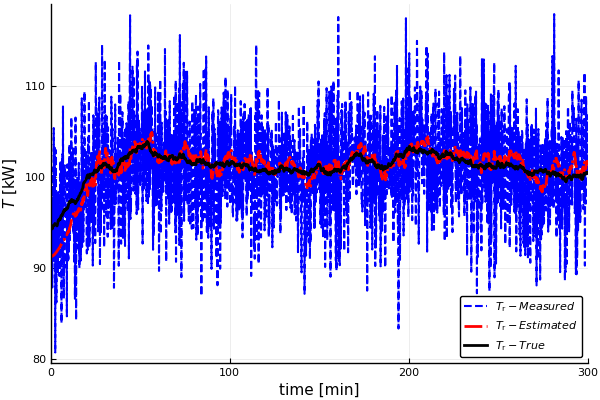

In [7]:

# Ensemble kalman filter

#function random_xw(xw,sd)
    #unpacking x
    #xw[1],xw[2],xw[3]=xw
   # xw[1]=rand(Normal(xw[1],sd))
   # xw[2]=rand(Normal(xw[2],sd))
   # xw[3]=rand(Normal(xw[3],sd))
   # return [xw[1],xw[2],xw[3]]  
#end
#This function will genrate random for v
#function random_v(v,sd)
    #return rand(Normal(v,sd))
#end

#This function returns f(xk,wk)
function process_f(x_state,w_noise)
    Trotor, Tstator, Tiron = x_state
    Taircold, Tairdelta, Tairhot = find_air_temperatures([Trotor, Tstator, Tiron], par)#[Tr0, Ts0, TFe0]
    Tr=Trotor + dt*(1.1*Rr*Ifd^2-UAr2d*(Trotor-Tairdelta))/(mr*chpCu)
    Ts=Tiron + dt*(3*Rs*It^2-UAs2Fe*(Tstator-Tiron))/(ms*chpCu)
    TFe=Tiron + dt*(UAs2Fe*(Tstator-Tiron)-UAFe2a*(Tiron-Tairhot)+QdFes)/(mFe*chpFe)
    xkkminus1= [Tr,Ts,TFe]+w_noise
    return xkkminus1
end

c=[1 0 0]
#Initialization
#states: mean=x0, var=0.1^2
x0=[94.,81.,70.]
# store initial in simulation x for plotting real system
x=x0
#process noise: mean=1, var=0.1^2
wk0=1e-1*[1.,1.,1.]
#meas noise: mean=1, var=0.1^2
vk0=5
# random points
np=10
# initial realization/particles
x00=zeros(3,np)
wk=zeros(3,np)
vk=zeros(np)
#Create random of x0~(mean=x0, var=X0)
# where mean(x)=[[94.,81.,70.], sd=[0.1,0.1,0.1], var=[0.1^2,.,.]]
# This function will generate random random values for w and x
#
#
#--Alg0rithm starts--
#
#
# Initialization
# calculating x00(i), wk(i),vk(i)

for i=1:np
    x00[:,i]=[rand(Normal(x0[1],2)), rand(Normal(x0[2],2)) ,rand(Normal(x0[3],2))]
    wk[:,i]=[rand(Normal(0,0.1)), rand(Normal(0,0.1)) ,rand(Normal(0,0.1))]
    vk[i]=rand(Normal(0,5))   
end
#for i=1:np
    #x00[:,i]=random_xw(x0,2)
   # wk[:,i]=random_xw(wk0,2)
    #vk[i]=random_v(vk0,2)
#end

xhat00mulnp=zeros(3,1)
X00mulnpminus1=zeros(3,3)
# calculate xhat00
for i=1:np
    xhat00mulnp=xhat00mulnp+x00[:,i]
end
xhat00=xhat00mulnp/np
#calculate X00
for i=1:np
    X00mulnpminus1=X00mulnpminus1+(x00[:,i]-xhat00)*transpose(x00[:,i]-xhat00)
end
X00=X00mulnpminus1/(np-1)
dt=10
t_sim=range(0,step=dt,stop=300*60)
xtrue, ymeas, xest=zeros(0),zeros(0),zeros(0)
Tsest, TFeest=zeros(0),zeros(0)
for j=1:length(t_sim)
    # Simulating model
    #Tr0, Ts0, TFe0=states
    x=process_f(x,wk0*rand(Normal()))#[Tr0, Ts0, TFe0]
    
    # Our measurement is only Tr
    yk=x[1]+vk0*rand(Normal())
    
    # Propagation step
    #
    xkkminus1=zeros(3,np)
    for i=1:np
        xkkminus1[:,i]=process_f(x00[:,i],wk[:,i])
    end
    xhatkkminus1mulnp=zeros(3,1)
    Xkkminus1mulnpminus1=zeros(3,3)
    #calulate xhatkkminus1
    for i=1:np
        xhatkkminus1mulnp=xhatkkminus1mulnp+xkkminus1[:,i]
    end
    xhatkkminus1=xhatkkminus1mulnp/np
    #calculate Xkkminus1: this is redundanat and can be ommited
    for i=1:np
        Xkkminus1mulnpminus1=Xkkminus1mulnpminus1+(xkkminus1[:,i]-xhatkkminus1)*transpose(xkkminus1[:,i]-xhatkkminus1)
    end
    Xkkminus1=Xkkminus1mulnpminus1/(np-1)

    # Information update
    # Measurement and innovation
    # find ykkminus1 from xkkminus1 and vk
    ykkminus1=zeros(1,np)
    for i=1:np
    # measured state is Tr
        ykkminus1[1,i]=xkkminus1[1,i]+vk[i]
    end
    #calculate yhatkkminus1
    yhatkkminus1mulnp=zeros(1,1)
    for i=1:np
        yhatkkminus1mulnp=@. yhatkkminus1mulnp+ykkminus1[1,i]
    end
    yhatkkminus1=yhatkkminus1mulnp/np

    # Cross and innovation covariance
    #calculate Zkkminus1
    Zkkminus1mulnpminus1=zeros(3,1)
    ekkminus1mulnpminus1=zeros(1,1)
    for i=1:np
        Zkkminus1mulnpminus1= @. Zkkminus1mulnpminus1+(xkkminus1[:,i]-xhatkkminus1)*transpose(ykkminus1[1,i]-yhatkkminus1)
    end
    Zkkminus1=Zkkminus1mulnpminus1/(np-1)
    # calculate innovation covariance
    for i=1:np
        ekkminus1mulnpminus1= @. ekkminus1mulnpminus1+(ykkminus1[1,i]-yhatkkminus1)*transpose(ykkminus1[1,i]-yhatkkminus1)
    end
    ekkminus1=ekkminus1mulnpminus1/(np-1)

    # Compute Kalman gain
    Kk=Zkkminus1*inv(ekkminus1)

    # a posteriori state esitmate
    # store in initializer x00
    for i=1:np
        x00[:,i]=@. xkkminus1[:,i]+Kk*(yk-ykkminus1[1,i])
    end
    # store in initializer xhat00
    xhatkkmulnp=zeros(3,1)
    for i=1:np
        xhatkkmulnp=xhatkkmulnp+x00[:,i]
    end
    xhat00=xhatkkmulnp/np
    # store in X00
    Xkkmulnpminus1=zeros(3,3)
    for i=1:np
        Xkkmulnpminus1=Xkkmulnpminus1+(x00[:,i]-xhat00)*transpose(x00[:,i]-xhat00)
    end
    X00=Xkkmulnpminus1/(np-1)
    # for plotting
    append!(xtrue,x[1])
    append!(ymeas,yk)
    append!(xest,xhat00[1])
    #print(xhat00)
    #print("\n")
    #print(X00)
    #print("\n")
    # end of K=0, initial step
end
#print(length(xest))
#print("\n")
#print(length(t_sim))
plot(t_sim/60, ymeas, lc=:blue,lw=1.5,ls=:dash,label=L"$T_\mathrm{r}-Measured$" )
plot!(t_sim/60, xest, lc=:red,lw=2,ls=:dashdot,label=L"$T_\mathrm{r}-Estimated$")
plot!(t_sim/60, xtrue, lc=:black,lw=2,label=L"$T_\mathrm{r}-True$")
#plot!(t_sim/60, xtrue-xest)
#plot!(t_sim/60, Tsest)
#plot!(t_sim/60, TFeest)
plot!(xlim=(0,300))
plot!(xlabel="time [min]",ylabel=L"$T$ $\mathrm{[kW]}$")

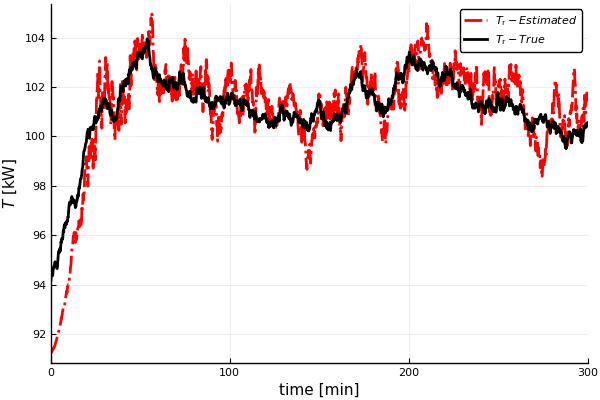

In [8]:
#plot(t_sim/60, ymeas, lc=:blue,lw=1.5,ls=:dash,label=L"$T_\mathrm{r}-Measured$" )
plot(t_sim/60, xest, lc=:red,lw=2,ls=:dashdot,label=L"$T_\mathrm{r}-Estimated$")
plot!(t_sim/60, xtrue, lc=:black,lw=2,label=L"$T_\mathrm{r}-True$")
#plot!(t_sim/60, xtrue-xest)
#plot!(t_sim/60, Tsest)
#plot!(t_sim/60, TFeest)
plot!(xlim=(0,300))
plot!(xlabel="time [min]",ylabel=L"$T$ $\mathrm{[kW]}$")

In [27]:
x=zeros(50)
for i=1:50
    x[i]=2*rand()+2
end
x

50-element Array{Float64,1}:
 3.930051571320865 
 2.0121182933424278
 3.6327742869769395
 3.658928418939143 
 3.4819211337431923
 3.9444663464323964
 3.2125965369021503
 3.1050660211830534
 3.113654090206057 
 2.6209763629455027
 3.434184525094466 
 3.2541945859261325
 3.2846658268368207
 ⋮                 
 2.2632606760735205
 3.775269916177501 
 3.0460151570503537
 2.2040240918419998
 2.4634783006380103
 3.5684239934230364
 2.832337918446527 
 3.2571741852688665
 2.5467378320878193
 2.075044182787698 
 3.1517748227199847
 3.1672379091187444

In [51]:
np=50
x00=zeros(3,np)
for i=1:50
    x00[:,i]=[rand(Normal(10,2)), rand(Normal(1,2)) ,rand(Normal(100,2))]
end
x00

3×50 Array{Float64,2}:
 10.1626    9.35682   11.183      …   7.13665   8.80893    9.02988 
  3.85802   0.702754  -0.0229409      6.18117  -3.55761   -0.240049
 99.5765   97.4752    96.8378        99.2175   96.161    102.643   

In [33]:
var(x)

NaN

In [34]:
std(x)

NaN